# Simple demo of PIICM

Leiv Rønneberg, July 2023



## Introduction

PIICM is a probabilistic framework for dose-response prediction of drug combination in cancer. In this notebook, a short demonstration is given of the model, and how it is used to predict dose-response in unperformed experiments.

At its core, the model is a simple variation of the classic Intrinsic Coregionalisation Model from spatial statistics, but is tailored to dose-response prediction in two major ways:
1. The model is made invariant to a certain permutation of its inputs through its prior, and
2. the model weights observations according to experimental quality through its likelihood.

Making use of efficient Kronecker structure of the kernel matrices, the PIICM is able to learn from noisy and sparsely observed datasets and accurately predict dose-response in held out experiments.

## Background

In-vitro drug combination experiments are performed on cancer cell lines in order to find novel treatments and to study drug interaction. These experiments are performed using many drugs, in different concentrations and tested on many different cancer cell lines, producing large datasets.

For a given drug concentration $\mathbf{x}=(x_1,x_2)$ where $x_i$ denotes the drug concentration of the $i$th drug, the dose-response function $f:\mathbb{R}^2 \to [0,1]$ maps drug concentrations to a measure of cell viability (zero indicating all cells are dead, and one that all cells are still alive).

In drug-combination datasets, $f$ is frequently decomposed as 
$$
f(\mathbf{x})=p_0(\mathbf{x})+\Delta(\mathbf{x}),
$$
where $p_0(\mathbf{x})$ denotes a non-interaction assumption and $\Delta$ the drug interaction. The non-interaction assumption is assumed known for all drug combinations prior to modelling, and hence predicting the dose-response function amounts to predicting 



As input, the model needs:

1. a matrix of drug concentrations $\mathbf{X}\in\mathbb{R}^{n \times 2}$, where each row corresponds to a unique concentrations pair,
2. a matrix of responses $\mathbf{Y}\in\mathbb{R}^{n \times m}$, where $m$ denotes the number of outputs in the training dataset, and
3. a matrix of corresponding noise terms $\mathbf{S}\in\mathbb{R}^{n \times m}$.




## Setting up the model

In [51]:
# Initial imports
import math
import torch
import gpytorch
import numpy as np
import pandas as pd

In [52]:
# Set some constants
N_combinations = 50
N_cellLines = 39
# Reading in the data
X = torch.tensor(pd.read_csv("data/ONeil_concentrations.csv").values).float()
Y = torch.tensor(pd.read_csv("data/ONeil_GP_subset.csv").values).float()
S = torch.tensor(pd.read_csv("data/ONeil_noise_subset.csv").values).float()

In [53]:
# Pulling out a test dataset
idx = 40
Y_test = Y.clone()[:,idx]
Y[:,idx] = float('nan')

In [54]:
# GPU acceleration
#mps_device = torch.device("mps")
#X = X.to(mps_device)
#X = Y.to(mps_device)
#X = S.to(mps_device)

In [55]:
# Do some reshaping to get the data in the correct format
n, p = Y.shape
p = 2*p
tmp = torch.full([n,p],float('nan'))
tmp_noise = torch.full([n,p],float('nan'))
for i in range(N_cellLines):
            orig = Y[:,(i*N_combinations):(i*N_combinations+N_combinations)]
            orig_noise = S[:,(i*N_combinations):(i*N_combinations+N_combinations)]
            new = torch.full(orig.shape,float('nan'))
            new_noise = torch.full(orig.shape,float('nan'))
            combined = torch.cat([orig,new],-1)
            combined_noise = torch.cat([orig_noise,new_noise],-1)
            tmp[:,(i*(2*N_combinations)):(i*(2*N_combinations)+2*N_combinations)] = combined
            tmp_noise[:,(i*(2*N_combinations)):(i*(2*N_combinations)+2*N_combinations)] = combined_noise
Y = tmp
S = tmp_noise
# Fill in missing values with dummy variables and mask
# Pad with missing values and large noise
mVAL = -999
mVAR = 99999999999999
missing_idx = Y.isnan()
N_missing = missing_idx.sum()
# Train output is given a fixed dummy values
Y = Y.masked_fill(missing_idx, mVAL)
# Correspondingly these are given a large noise
S = S.masked_fill(missing_idx, mVAR)

In [64]:
# Define some constants
N_tasks = int(2 * N_combinations * N_cellLines)
N_total = Y.numel()
N_obs = int(N_total - N_missing)
drugRank = 25
cellRank = 20
symmetric = True
maxiter=200
tol=1e-6
cg_tol=0.005
eval_cg_tol=0.005

In [65]:
# Here now set up the model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=N_tasks
        )
        self.covar_module = gpytorch.kernels.DrugResponseKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            num_combinations=N_combinations, num_cell_lines=N_cellLines,
            drug_rank=drugRank, cell_linerank=cellRank,
            symmetric=symmetric
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.FixedNoiseMultitaskGaussianLikelihood(num_tasks=N_tasks,
                                                                        noise=S)
model = MultitaskGPModel(X, Y, likelihood)

In [66]:
# GPU acceleratioj
#model = model.to(mps_device)
#likelihood = likelihood.to(mps_device)


In [67]:
# Training
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
# Keeping track of loss
m = []
diff = 10
with gpytorch.settings.verbose_linalg(True), gpytorch.settings.max_preconditioner_size(0):
    with gpytorch.settings.use_eigvalsh(True), gpytorch.settings.max_cg_iterations(2000):
        with gpytorch.settings.cg_tolerance(cg_tol):
            for i in range(maxiter):
                optimizer.zero_grad()
                output = model(X)
                loss = -mll(output, Y)
                loss.backward()
                optimizer.step()
                m.append(loss.item())
                if i > 0:
                    diff = abs(m[i] - m[i - 1])
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  loss difference: %.4f' % (
                    i + 1, maxiter, loss.item(),
                    model.covar_module.data_covar_module.base_kernel.lengthscale.item(),
                    model.likelihood.global_noise.item(),
                    diff
                ))
                if diff < tol:
                    print('Model converged!')
                    break

LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 32 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 1/200 - Loss: 0.972   lengthscale: 0.644   noise: 0.644  loss difference: 10.0000


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 2/200 - Loss: 0.963   lengthscale: 0.599   noise: 0.598  loss difference: 0.0090


LinAlg (Verbose) - DEBUG - CG converged after 113 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 3/200 - Loss: 0.957   lengthscale: 0.555   noise: 0.555  loss difference: 0.0065


LinAlg (Verbose) - DEBUG - CG converged after 142 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 4/200 - Loss: 0.951   lengthscale: 0.514   noise: 0.513  loss difference: 0.0054


LinAlg (Verbose) - DEBUG - CG converged after 164 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 5/200 - Loss: 0.947   lengthscale: 0.476   noise: 0.475  loss difference: 0.0044


LinAlg (Verbose) - DEBUG - CG converged after 181 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 6/200 - Loss: 0.943   lengthscale: 0.439   noise: 0.438  loss difference: 0.0040


LinAlg (Verbose) - DEBUG - CG converged after 188 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 7/200 - Loss: 0.939   lengthscale: 0.405   noise: 0.404  loss difference: 0.0038


LinAlg (Verbose) - DEBUG - CG converged after 186 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 8/200 - Loss: 0.936   lengthscale: 0.373   noise: 0.373  loss difference: 0.0036


LinAlg (Verbose) - DEBUG - CG converged after 183 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 9/200 - Loss: 0.932   lengthscale: 0.344   noise: 0.343  loss difference: 0.0033


LinAlg (Verbose) - DEBUG - CG converged after 452 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 10/200 - Loss: 0.929   lengthscale: 0.318   noise: 0.316  loss difference: 0.0032


LinAlg (Verbose) - DEBUG - CG converged after 330 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 11/200 - Loss: 0.926   lengthscale: 0.293   noise: 0.291  loss difference: 0.0029


LinAlg (Verbose) - DEBUG - CG converged after 640 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 12/200 - Loss: 0.924   lengthscale: 0.272   noise: 0.268  loss difference: 0.0025


LinAlg (Verbose) - DEBUG - CG converged after 633 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 13/200 - Loss: 0.922   lengthscale: 0.253   noise: 0.247  loss difference: 0.0021


LinAlg (Verbose) - DEBUG - CG converged after 910 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 14/200 - Loss: 0.920   lengthscale: 0.237   noise: 0.228  loss difference: 0.0018


LinAlg (Verbose) - DEBUG - CG converged after 775 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 15/200 - Loss: 0.918   lengthscale: 0.224   noise: 0.210  loss difference: 0.0017


LinAlg (Verbose) - DEBUG - CG converged after 718 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 16/200 - Loss: 0.916   lengthscale: 0.214   noise: 0.194  loss difference: 0.0015


LinAlg (Verbose) - DEBUG - CG converged after 519 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 17/200 - Loss: 0.915   lengthscale: 0.207   noise: 0.179  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 885 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 18/200 - Loss: 0.913   lengthscale: 0.203   noise: 0.166  loss difference: 0.0018


LinAlg (Verbose) - DEBUG - CG converged after 912 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 19/200 - Loss: 0.911   lengthscale: 0.201   noise: 0.154  loss difference: 0.0022


LinAlg (Verbose) - DEBUG - CG converged after 578 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 20/200 - Loss: 0.909   lengthscale: 0.201   noise: 0.143  loss difference: 0.0024


LinAlg (Verbose) - DEBUG - CG converged after 545 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 21/200 - Loss: 0.906   lengthscale: 0.203   noise: 0.133  loss difference: 0.0026


LinAlg (Verbose) - DEBUG - CG converged after 372 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 22/200 - Loss: 0.903   lengthscale: 0.207   noise: 0.124  loss difference: 0.0026


LinAlg (Verbose) - DEBUG - CG converged after 239 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 23/200 - Loss: 0.901   lengthscale: 0.213   noise: 0.116  loss difference: 0.0026


LinAlg (Verbose) - DEBUG - CG converged after 290 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 24/200 - Loss: 0.898   lengthscale: 0.219   noise: 0.108  loss difference: 0.0025


LinAlg (Verbose) - DEBUG - CG converged after 311 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 25/200 - Loss: 0.896   lengthscale: 0.225   noise: 0.102  loss difference: 0.0023


LinAlg (Verbose) - DEBUG - CG converged after 271 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 26/200 - Loss: 0.894   lengthscale: 0.232   noise: 0.095  loss difference: 0.0021


LinAlg (Verbose) - DEBUG - CG converged after 216 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 27/200 - Loss: 0.892   lengthscale: 0.239   noise: 0.090  loss difference: 0.0018


LinAlg (Verbose) - DEBUG - CG converged after 93 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 28/200 - Loss: 0.891   lengthscale: 0.245   noise: 0.085  loss difference: 0.0015


LinAlg (Verbose) - DEBUG - CG converged after 92 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 29/200 - Loss: 0.889   lengthscale: 0.251   noise: 0.080  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 69 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 30/200 - Loss: 0.888   lengthscale: 0.255   noise: 0.076  loss difference: 0.0010


LinAlg (Verbose) - DEBUG - CG converged after 67 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 31/200 - Loss: 0.888   lengthscale: 0.257   noise: 0.072  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - CG converged after 67 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 32/200 - Loss: 0.887   lengthscale: 0.259   noise: 0.069  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 69 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 33/200 - Loss: 0.887   lengthscale: 0.259   noise: 0.066  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 69 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 34/200 - Loss: 0.886   lengthscale: 0.258   noise: 0.063  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 72 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 35/200 - Loss: 0.886   lengthscale: 0.256   noise: 0.060  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 74 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 36/200 - Loss: 0.886   lengthscale: 0.253   noise: 0.058  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 85 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 37/200 - Loss: 0.886   lengthscale: 0.250   noise: 0.056  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 77 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 38/200 - Loss: 0.886   lengthscale: 0.246   noise: 0.054  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 78 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 39/200 - Loss: 0.886   lengthscale: 0.241   noise: 0.052  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 79 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 40/200 - Loss: 0.886   lengthscale: 0.237   noise: 0.050  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 41/200 - Loss: 0.886   lengthscale: 0.233   noise: 0.048  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 42/200 - Loss: 0.887   lengthscale: 0.229   noise: 0.047  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 43/200 - Loss: 0.887   lengthscale: 0.226   noise: 0.046  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 44/200 - Loss: 0.887   lengthscale: 0.224   noise: 0.044  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 79 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 45/200 - Loss: 0.887   lengthscale: 0.222   noise: 0.043  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 46/200 - Loss: 0.887   lengthscale: 0.220   noise: 0.042  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 93 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 47/200 - Loss: 0.887   lengthscale: 0.220   noise: 0.041  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 79 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 48/200 - Loss: 0.887   lengthscale: 0.220   noise: 0.040  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 49/200 - Loss: 0.887   lengthscale: 0.221   noise: 0.039  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 50/200 - Loss: 0.887   lengthscale: 0.222   noise: 0.038  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 51/200 - Loss: 0.887   lengthscale: 0.223   noise: 0.038  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 52/200 - Loss: 0.886   lengthscale: 0.224   noise: 0.037  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 81 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 53/200 - Loss: 0.886   lengthscale: 0.226   noise: 0.036  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 54/200 - Loss: 0.886   lengthscale: 0.227   noise: 0.036  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 82 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 55/200 - Loss: 0.886   lengthscale: 0.228   noise: 0.035  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 82 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 56/200 - Loss: 0.885   lengthscale: 0.229   noise: 0.034  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 79 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 57/200 - Loss: 0.885   lengthscale: 0.230   noise: 0.034  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 82 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 58/200 - Loss: 0.885   lengthscale: 0.230   noise: 0.033  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 82 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 59/200 - Loss: 0.885   lengthscale: 0.230   noise: 0.033  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 81 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 60/200 - Loss: 0.885   lengthscale: 0.229   noise: 0.032  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 61/200 - Loss: 0.885   lengthscale: 0.229   noise: 0.032  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 83 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 62/200 - Loss: 0.885   lengthscale: 0.228   noise: 0.031  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 81 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 63/200 - Loss: 0.885   lengthscale: 0.226   noise: 0.031  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 83 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 64/200 - Loss: 0.885   lengthscale: 0.225   noise: 0.031  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 80 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 65/200 - Loss: 0.885   lengthscale: 0.224   noise: 0.030  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 82 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 66/200 - Loss: 0.885   lengthscale: 0.223   noise: 0.030  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 82 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 67/200 - Loss: 0.885   lengthscale: 0.222   noise: 0.029  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 81 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 68/200 - Loss: 0.885   lengthscale: 0.221   noise: 0.029  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 95 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 69/200 - Loss: 0.886   lengthscale: 0.221   noise: 0.029  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 130 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 70/200 - Loss: 0.885   lengthscale: 0.220   noise: 0.028  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 85 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 71/200 - Loss: 0.885   lengthscale: 0.220   noise: 0.028  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 85 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 72/200 - Loss: 0.885   lengthscale: 0.221   noise: 0.028  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 91 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 73/200 - Loss: 0.886   lengthscale: 0.221   noise: 0.027  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 88 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 74/200 - Loss: 0.885   lengthscale: 0.221   noise: 0.027  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 90 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 75/200 - Loss: 0.885   lengthscale: 0.222   noise: 0.027  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 94 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 76/200 - Loss: 0.885   lengthscale: 0.222   noise: 0.026  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 189 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 77/200 - Loss: 0.885   lengthscale: 0.222   noise: 0.026  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 93 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 78/200 - Loss: 0.885   lengthscale: 0.223   noise: 0.026  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 134 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 79/200 - Loss: 0.885   lengthscale: 0.223   noise: 0.026  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 180 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 80/200 - Loss: 0.885   lengthscale: 0.223   noise: 0.025  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 130 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 81/200 - Loss: 0.885   lengthscale: 0.222   noise: 0.025  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 133 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 82/200 - Loss: 0.886   lengthscale: 0.222   noise: 0.025  loss difference: 0.0007


LinAlg (Verbose) - DEBUG - CG converged after 106 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 83/200 - Loss: 0.885   lengthscale: 0.221   noise: 0.024  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 109 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 84/200 - Loss: 0.886   lengthscale: 0.220   noise: 0.024  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 204 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 85/200 - Loss: 0.886   lengthscale: 0.219   noise: 0.024  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 131 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 86/200 - Loss: 0.887   lengthscale: 0.218   noise: 0.024  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - CG converged after 236 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 87/200 - Loss: 0.885   lengthscale: 0.218   noise: 0.023  loss difference: 0.0018


LinAlg (Verbose) - DEBUG - CG converged after 206 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 88/200 - Loss: 0.887   lengthscale: 0.218   noise: 0.023  loss difference: 0.0015


LinAlg (Verbose) - DEBUG - CG converged after 131 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 89/200 - Loss: 0.886   lengthscale: 0.218   noise: 0.023  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 271 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 90/200 - Loss: 0.888   lengthscale: 0.217   noise: 0.023  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 206 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 91/200 - Loss: 0.887   lengthscale: 0.217   noise: 0.022  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - CG converged after 150 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 92/200 - Loss: 0.886   lengthscale: 0.218   noise: 0.022  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 208 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 93/200 - Loss: 0.887   lengthscale: 0.218   noise: 0.022  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 405 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 94/200 - Loss: 0.887   lengthscale: 0.218   noise: 0.022  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 138 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 95/200 - Loss: 0.888   lengthscale: 0.218   noise: 0.021  loss difference: 0.0007


LinAlg (Verbose) - DEBUG - CG converged after 346 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 96/200 - Loss: 0.887   lengthscale: 0.218   noise: 0.021  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 139 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 97/200 - Loss: 0.887   lengthscale: 0.218   noise: 0.021  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - CG converged after 292 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 98/200 - Loss: 0.888   lengthscale: 0.218   noise: 0.021  loss difference: 0.0007


LinAlg (Verbose) - DEBUG - CG converged after 347 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 99/200 - Loss: 0.888   lengthscale: 0.218   noise: 0.021  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 251 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 100/200 - Loss: 0.889   lengthscale: 0.217   noise: 0.020  loss difference: 0.0007


LinAlg (Verbose) - DEBUG - CG converged after 177 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 101/200 - Loss: 0.888   lengthscale: 0.217   noise: 0.020  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - CG converged after 445 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 102/200 - Loss: 0.888   lengthscale: 0.216   noise: 0.020  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 306 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 103/200 - Loss: 0.889   lengthscale: 0.215   noise: 0.020  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 256 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 104/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.019  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 555 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 105/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.019  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 326 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 106/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.019  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 375 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 107/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.019  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 152 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 108/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.019  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 152 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 109/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.018  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 412 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 110/200 - Loss: 0.889   lengthscale: 0.215   noise: 0.018  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 206 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 111/200 - Loss: 0.889   lengthscale: 0.215   noise: 0.018  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 152 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 112/200 - Loss: 0.889   lengthscale: 0.215   noise: 0.018  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 390 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 113/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.018  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 240 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 114/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.018  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 302 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 115/200 - Loss: 0.889   lengthscale: 0.215   noise: 0.017  loss difference: 0.0013


LinAlg (Verbose) - DEBUG - CG converged after 310 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 116/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.017  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 537 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 117/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.017  loss difference: 0.0011


LinAlg (Verbose) - DEBUG - CG converged after 408 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 118/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.017  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - CG converged after 173 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 119/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.017  loss difference: 0.0010


LinAlg (Verbose) - DEBUG - CG converged after 411 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 120/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.017  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 605 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 121/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.016  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 302 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 122/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.016  loss difference: 0.0011


LinAlg (Verbose) - DEBUG - CG converged after 291 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 123/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.016  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 158 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 124/200 - Loss: 0.887   lengthscale: 0.215   noise: 0.016  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 540 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 125/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.016  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 179 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 126/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.016  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 659 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 127/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.015  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 243 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 128/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.015  loss difference: 0.0011


LinAlg (Verbose) - DEBUG - CG converged after 145 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 129/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.015  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 156 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 130/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.015  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 351 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 131/200 - Loss: 0.886   lengthscale: 0.215   noise: 0.015  loss difference: 0.0011


LinAlg (Verbose) - DEBUG - CG converged after 445 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 132/200 - Loss: 0.886   lengthscale: 0.215   noise: 0.015  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 530 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 133/200 - Loss: 0.887   lengthscale: 0.215   noise: 0.015  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 154 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 134/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.014  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - CG converged after 398 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 135/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.014  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 266 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 136/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.014  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 349 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 137/200 - Loss: 0.888   lengthscale: 0.213   noise: 0.014  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 484 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 138/200 - Loss: 0.888   lengthscale: 0.213   noise: 0.014  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 420 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 139/200 - Loss: 0.888   lengthscale: 0.212   noise: 0.014  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 383 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 140/200 - Loss: 0.889   lengthscale: 0.212   noise: 0.014  loss difference: 0.0014


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 447 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 141/200 - Loss: 0.888   lengthscale: 0.212   noise: 0.014  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 243 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 142/200 - Loss: 0.887   lengthscale: 0.212   noise: 0.013  loss difference: 0.0007


LinAlg (Verbose) - DEBUG - CG converged after 154 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 143/200 - Loss: 0.889   lengthscale: 0.213   noise: 0.013  loss difference: 0.0014


LinAlg (Verbose) - DEBUG - CG converged after 561 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 144/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.013  loss difference: 0.0013


LinAlg (Verbose) - DEBUG - CG converged after 152 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 145/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.013  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 560 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 146/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.013  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 577 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 147/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.013  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 610 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 148/200 - Loss: 0.887   lengthscale: 0.215   noise: 0.013  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - CG converged after 499 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 149/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.013  loss difference: 0.0014


LinAlg (Verbose) - DEBUG - CG converged after 684 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 150/200 - Loss: 0.888   lengthscale: 0.215   noise: 0.013  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 341 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 151/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.013  loss difference: 0.0010


LinAlg (Verbose) - DEBUG - CG converged after 200 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 152/200 - Loss: 0.888   lengthscale: 0.213   noise: 0.012  loss difference: 0.0010


LinAlg (Verbose) - DEBUG - CG converged after 634 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 153/200 - Loss: 0.889   lengthscale: 0.213   noise: 0.012  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - CG converged after 512 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 154/200 - Loss: 0.888   lengthscale: 0.212   noise: 0.012  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - CG converged after 177 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 155/200 - Loss: 0.888   lengthscale: 0.212   noise: 0.012  loss difference: 0.0001


LinAlg (Verbose) - DEBUG - CG converged after 363 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 156/200 - Loss: 0.889   lengthscale: 0.211   noise: 0.012  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 607 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 157/200 - Loss: 0.889   lengthscale: 0.211   noise: 0.012  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 530 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 158/200 - Loss: 0.888   lengthscale: 0.211   noise: 0.012  loss difference: 0.0009


LinAlg (Verbose) - DEBUG - CG converged after 593 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 159/200 - Loss: 0.889   lengthscale: 0.211   noise: 0.012  loss difference: 0.0006


LinAlg (Verbose) - DEBUG - CG converged after 191 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 160/200 - Loss: 0.889   lengthscale: 0.211   noise: 0.012  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 253 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 161/200 - Loss: 0.889   lengthscale: 0.211   noise: 0.012  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 210 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 162/200 - Loss: 0.889   lengthscale: 0.212   noise: 0.012  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - CG converged after 759 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 163/200 - Loss: 0.889   lengthscale: 0.212   noise: 0.011  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - CG converged after 255 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 164/200 - Loss: 0.890   lengthscale: 0.212   noise: 0.011  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 585 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 165/200 - Loss: 0.889   lengthscale: 0.213   noise: 0.011  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 397 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 166/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.011  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 630 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 167/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.011  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 286 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 168/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.011  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 339 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 169/200 - Loss: 0.887   lengthscale: 0.214   noise: 0.011  loss difference: 0.0007


LinAlg (Verbose) - DEBUG - CG converged after 182 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 170/200 - Loss: 0.888   lengthscale: 0.214   noise: 0.011  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 334 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 171/200 - Loss: 0.888   lengthscale: 0.212   noise: 0.011  loss difference: 0.0005


LinAlg (Verbose) - DEBUG - CG converged after 558 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 172/200 - Loss: 0.887   lengthscale: 0.211   noise: 0.011  loss difference: 0.0010


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 306 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 173/200 - Loss: 0.888   lengthscale: 0.210   noise: 0.011  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - CG converged after 794 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 174/200 - Loss: 0.889   lengthscale: 0.209   noise: 0.011  loss difference: 0.0010


LinAlg (Verbose) - DEBUG - CG converged after 588 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 175/200 - Loss: 0.888   lengthscale: 0.208   noise: 0.010  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 390 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 176/200 - Loss: 0.888   lengthscale: 0.208   noise: 0.010  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 698 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 177/200 - Loss: 0.890   lengthscale: 0.209   noise: 0.010  loss difference: 0.0017


LinAlg (Verbose) - DEBUG - CG converged after 220 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 178/200 - Loss: 0.889   lengthscale: 0.209   noise: 0.010  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 346 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 179/200 - Loss: 0.888   lengthscale: 0.211   noise: 0.010  loss difference: 0.0010


LinAlg (Verbose) - DEBUG - CG converged after 614 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 180/200 - Loss: 0.890   lengthscale: 0.212   noise: 0.010  loss difference: 0.0024


LinAlg (Verbose) - DEBUG - CG converged after 178 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 181/200 - Loss: 0.890   lengthscale: 0.213   noise: 0.010  loss difference: 0.0004


LinAlg (Verbose) - DEBUG - CG converged after 747 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 182/200 - Loss: 0.888   lengthscale: 0.213   noise: 0.010  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 507 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 183/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.010  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 477 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 184/200 - Loss: 0.889   lengthscale: 0.214   noise: 0.010  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 178 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 185/200 - Loss: 0.888   lengthscale: 0.213   noise: 0.010  loss difference: 0.0013


LinAlg (Verbose) - DEBUG - CG converged after 621 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 186/200 - Loss: 0.888   lengthscale: 0.213   noise: 0.010  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 730 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 187/200 - Loss: 0.889   lengthscale: 0.212   noise: 0.010  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 213 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 188/200 - Loss: 0.890   lengthscale: 0.211   noise: 0.010  loss difference: 0.0012


LinAlg (Verbose) - DEBUG - CG converged after 569 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 189/200 - Loss: 0.888   lengthscale: 0.210   noise: 0.010  loss difference: 0.0019


LinAlg (Verbose) - DEBUG - CG converged after 327 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 190/200 - Loss: 0.888   lengthscale: 0.209   noise: 0.009  loss difference: 0.0003


LinAlg (Verbose) - DEBUG - CG converged after 630 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 191/200 - Loss: 0.890   lengthscale: 0.209   noise: 0.009  loss difference: 0.0017


LinAlg (Verbose) - DEBUG - CG converged after 605 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 192/200 - Loss: 0.888   lengthscale: 0.209   noise: 0.009  loss difference: 0.0014


LinAlg (Verbose) - DEBUG - CG converged after 196 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 193/200 - Loss: 0.888   lengthscale: 0.210   noise: 0.009  loss difference: 0.0000


LinAlg (Verbose) - DEBUG - CG converged after 475 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 194/200 - Loss: 0.889   lengthscale: 0.211   noise: 0.009  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 439 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 195/200 - Loss: 0.890   lengthscale: 0.212   noise: 0.009  loss difference: 0.0015


LinAlg (Verbose) - DEBUG - CG converged after 787 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 196/200 - Loss: 0.887   lengthscale: 0.212   noise: 0.009  loss difference: 0.0034


LinAlg (Verbose) - DEBUG - CG converged after 206 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 197/200 - Loss: 0.889   lengthscale: 0.212   noise: 0.009  loss difference: 0.0023


LinAlg (Verbose) - DEBUG - CG converged after 177 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 198/200 - Loss: 0.889   lengthscale: 0.212   noise: 0.009  loss difference: 0.0002


LinAlg (Verbose) - DEBUG - CG converged after 637 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.005). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 199/200 - Loss: 0.888   lengthscale: 0.211   noise: 0.009  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 720 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 200/200 - Loss: 0.889   lengthscale: 0.211   noise: 0.009  loss difference: 0.0009


In [68]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.max_cg_iterations(4000), gpytorch.settings.eval_cg_tolerance(eval_cg_tol), gpytorch.settings.verbose_linalg(True), gpytorch.settings.skip_posterior_variances(True):
    predictions = likelihood(model(X))
    mean = predictions.mean

if symmetric:
    n,p = mean.shape
    p = int(p/2)
    tmp = torch.full([n,p], float('nan'))
    for i in range(N_cellLines):
        tmp[:,(i*N_combinations):(i*N_combinations+N_combinations)] = mean[:,(i*(2*N_combinations)):(i*(2*N_combinations)+N_combinations)]
    mean = tmp

LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 4000 iterations (tol=0.005). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 186 iterations.


## Plotting

In [69]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt

In [70]:
[Xt,Yt] = np.meshgrid(X[:,0].unique().numpy(),X[:,1].unique().numpy())

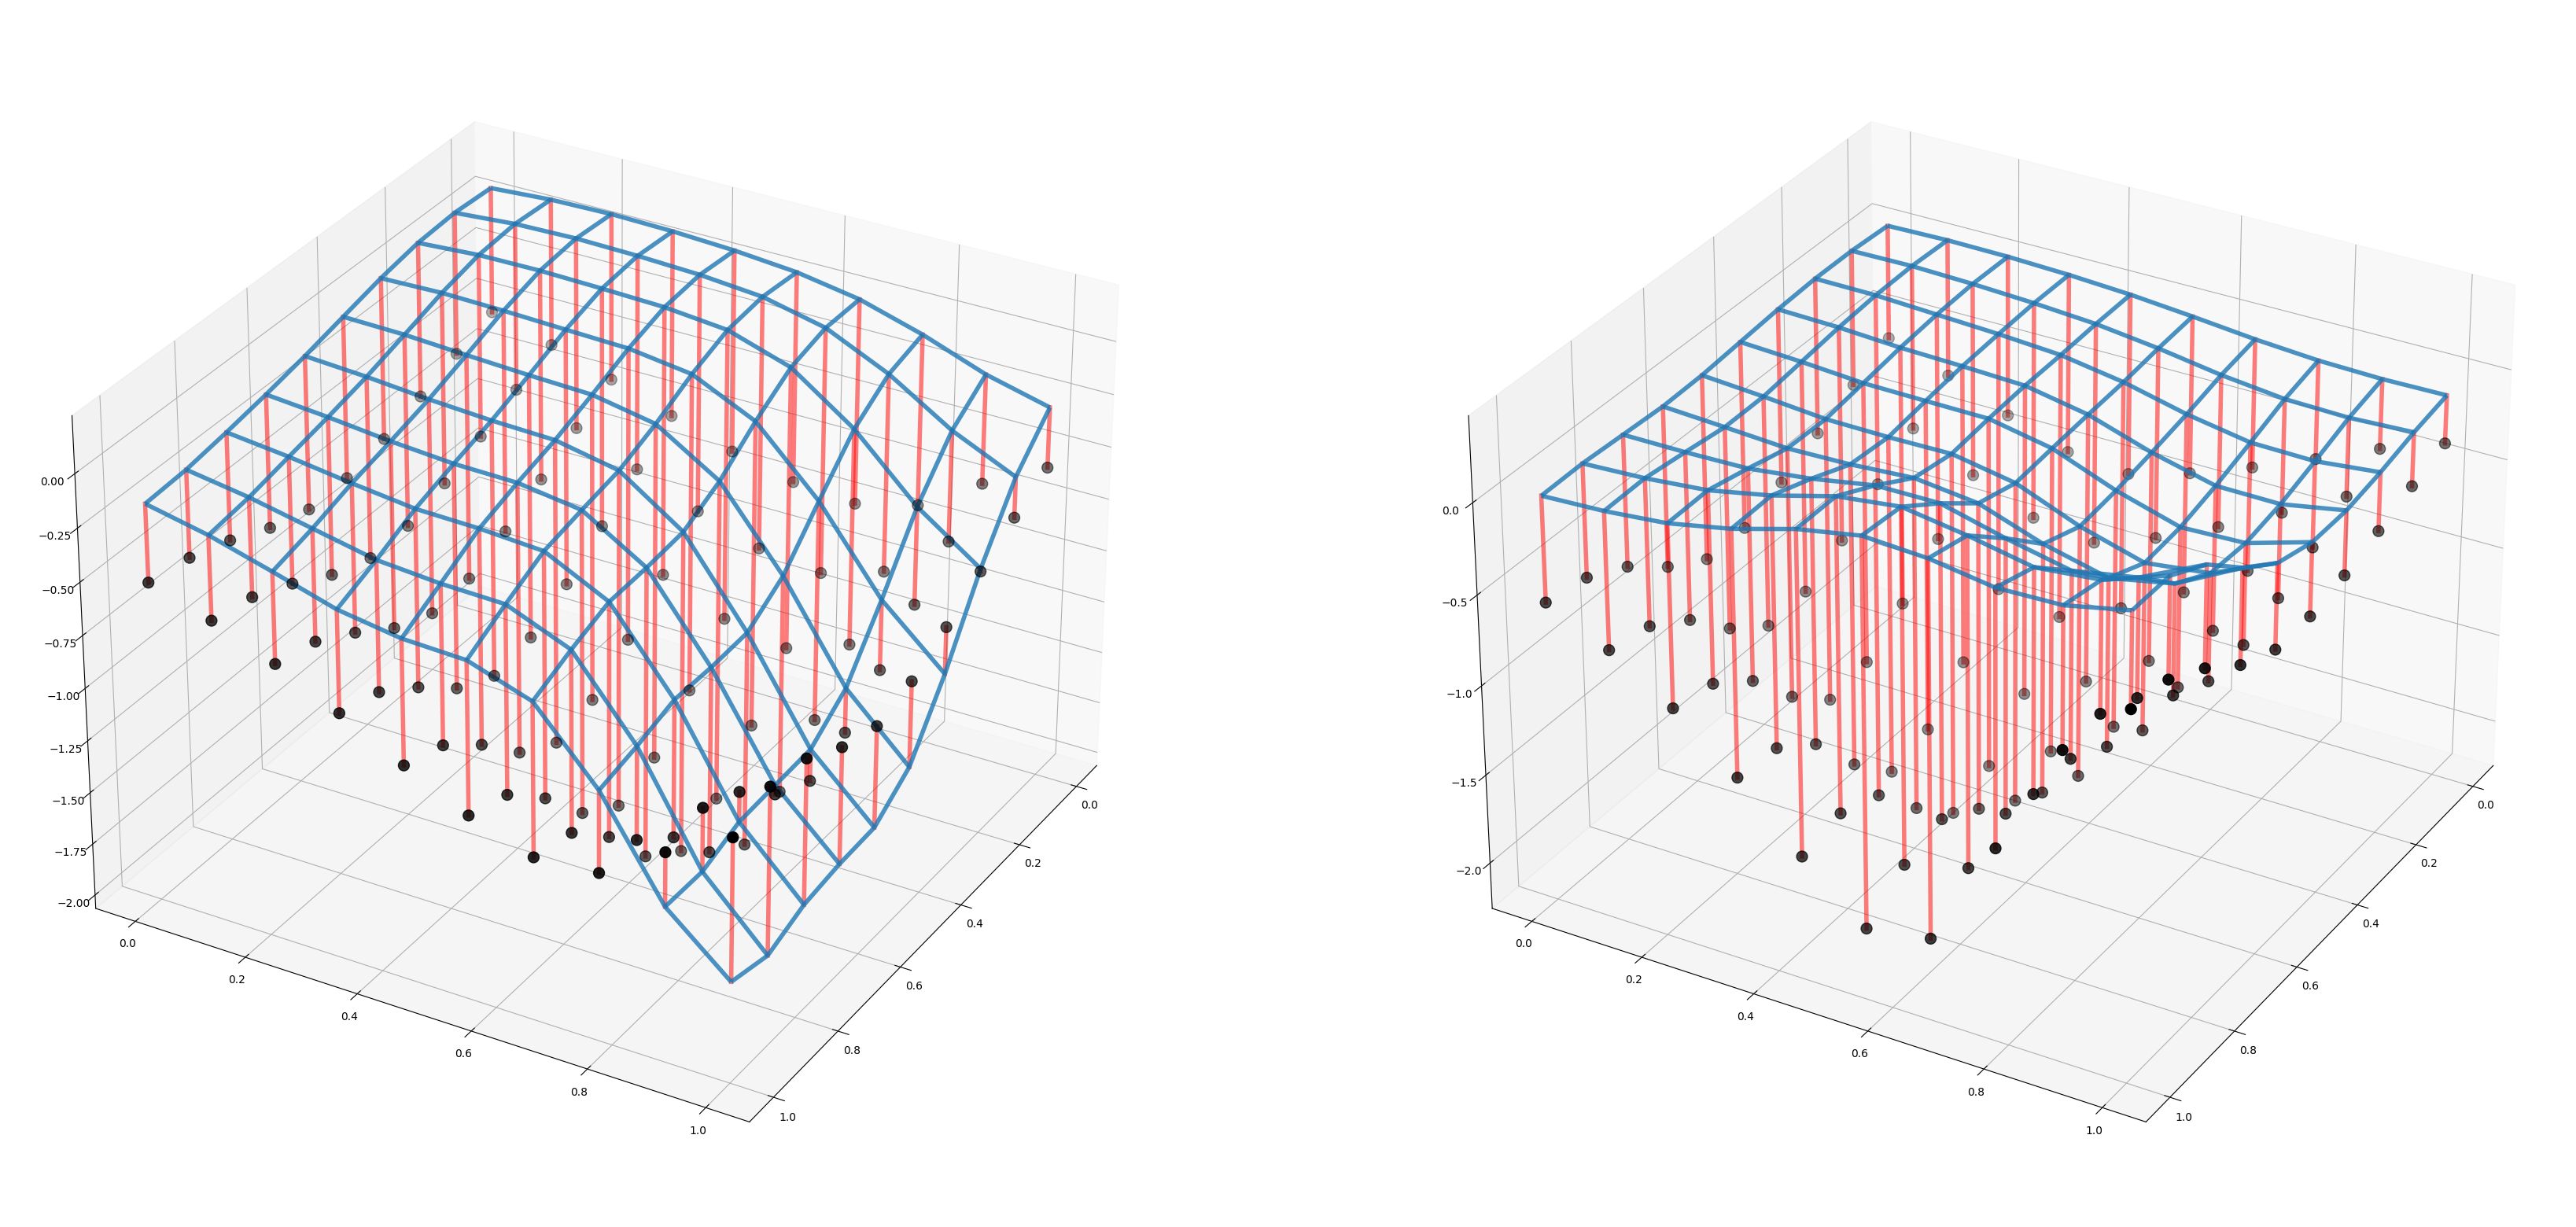

In [71]:
# Plotting for two tasks
task1 = 101
task2 = idx # The held out test-set
%matplotlib inline 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(42,20))


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])



ax1 = fig.add_subplot(1,2,1, projection="3d")
# Add surface
ax1.plot_wireframe(X=Xt,Y=Yt,Z=mean[:,task1].reshape(Xt.shape).detach().numpy(),cmap=plt.get_cmap('viridis'), alpha=0.8, linewidth=4 )
# Add points
ax1.scatter(Xt,Yt,Y[:,task1],c='k',s=100)
ax1.view_init(azim=30,elev=30)
# Add lines connecting each point to the surface
for kk in range(X.shape[0]):
    ax1.plot([X[kk,0],X[kk,0]],[X[kk,1],X[kk,1]],[mean[kk,task1],Y[kk,task1]],color="red",alpha=0.5,linewidth=4)

    
# Latent GP
ax2 = fig.add_subplot(1,2,2, projection="3d")

# Add surface
ax2.plot_wireframe(X=Xt,Y=Yt,Z=mean[:,task2].reshape(Xt.shape).detach().numpy(),cmap=plt.get_cmap('viridis'), alpha=0.8, linewidth=4 )
# Add points
ax2.scatter(Xt,Yt,Y_test,c='k',s=100)
ax2.view_init(azim=30,elev=30)
# Add lines connecting each point to the surface
for kk in range(X.shape[0]):
    ax2.plot([X[kk,0],X[kk,0]],[X[kk,1],X[kk,1]],[mean[kk,task2],Y_test[kk]],color="red",alpha=0.5, linewidth=4)
# Title